In [225]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

### 1. Data Preprocessing

In [4]:
# Load the user data
user_df = pd.read_csv('takehome_users.csv', encoding='latin1')

In [6]:
# Load the user engagement data
engagement_df = pd.read_csv('takehome_user_engagement.csv')

In [7]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [8]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [11]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [16]:
# Check for missing values in both datasets
print("\nMissing Values in User Data:")
print(user_df.isnull().sum())

print("\nMissing Values in Engagement Data:")
print(engagement_df.isnull().sum())


Missing Values in User Data:
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

Missing Values in Engagement Data:
time_stamp    0
user_id       0
visited       0
dtype: int64


In [18]:
# Convert relevant columns to datetime objects
user_df['creation_time'] = pd.to_datetime(user_df['creation_time'])
user_df['last_session_creation_time'] = pd.to_datetime(user_df['last_session_creation_time'], unit='s')
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

In [19]:
# Check the data types and info to ensure proper conversion
print("\nData Types in User Data:")
print(user_df.dtypes)

print("\nData Types in Engagement Data:")
print(engagement_df.dtypes)


Data Types in User Data:
object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object

Data Types in Engagement Data:
time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object


### 2. Define 'Adopted User'

In [21]:
# Sort the data by user_id and time_stamp
engagement_df = engagement_df.sort_values(by=['user_id', 'time_stamp'])

In [54]:
#Check if there are timestamps for the same user in the same day
(engagement_df.groupby('user_id')['time_stamp'].diff() < pd.Timedelta(days=1)).any()

False

In [141]:
# Check if users are unique and in range from 1 to 12000
engagement_df['user_id'].unique().tolist == [i for i in range(1, 12001)] 

False

In [202]:
# Define a function to check if a user is adopted
def is_adopted(user_data):
    
    #Create DataFrame for marking users adopted (1) or not (0)
    columns = ['user_id', 'is_adopted']
    df = pd.DataFrame(columns=columns)

    #Loop through unique user_id
    for j in user_data['user_id'].unique():
        
        #Find login timestamp for each user
        user_time = user_data[user_data['user_id'] == j]
    
        #Find difference between last and first login for the user
        last_first_diff = user_time.iloc[-1]['time_stamp'] - user_time.iloc[0]['time_stamp']

        #Check if difference between last and first login for the user is less or equal 7 days
        if last_first_diff <= pd.Timedelta(days=7):

            #Find sum of times user logged in during this period
            s = sum(user_time['visited'])

            #If user logged in 3 or more times then mark him as adopted
            if s>=3:
                adopted = 1
            else:
                adopted = 0

        else: #If difference between last and first login for the user is more then 7 days

            s=0

            for i in range(len(user_time['time_stamp'])-2):

                #Find 7 days window starts with each login except last 2
                window = user_time.iloc[i]['time_stamp'] + pd.Timedelta(days=7)

                #Find the third login for each login
                third_login = user_time.iloc[i+2]['time_stamp']

                #Check if the time of third login is in 7 days window 
                if window >= third_login:
                    s+=1
                    if s!=0:
                        adopted = 1
                    else:
                        adopted = 0
                        
        data = {'user_id': j, 'is_adopted': adopted}
        df = df.append(data, ignore_index=True)
        
    return df

In [203]:
# Apply the function to each user's data
adopted_users_df = is_adopted(engagement_df)
adopted_users_df

,user_id,is_adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
...,...,...
8818,11996,0
8819,11997,0
8820,11998,0
8821,11999,0


In [204]:
# Merge user data with adopted user information
user_df = user_df.merge(adopted_users_df, left_on='object_id', right_on='user_id', how='left')
user_df

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,is_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,3,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,4,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,11996,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,11997,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,11998,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,11999,0


In [206]:
# Fill missing values with 0 (users who are not adopted)
user_df['is_adopted'] = user_df['is_adopted'].fillna(0).astype(int)

### 3. Feature engineering

In [207]:
# Extract date-related features
user_df['creation_year'] = user_df['creation_time'].dt.year
user_df['creation_month'] = user_df['creation_time'].dt.month
user_df['creation_day'] = user_df['creation_time'].dt.day
user_df['creation_day_of_week'] = user_df['creation_time'].dt.dayofweek

In [209]:
# Calculate time since account creation in days
user_df['days_since_creation'] = (user_df['last_session_creation_time'])

In [210]:
# Create dummy variables for 'creation_source'
user_data = pd.get_dummies(user_data, columns=['creation_source'], prefix='source', drop_first=True)

In [221]:
# Merge user_df and engagement_df based on 'user_id'
merged_df = pd.merge(user_df, engagement_df, left_on='user_id', right_on='user_id', how='inner')
merged_df

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,is_adopted,creation_year,creation_month,creation_day,creation_day_of_week,days_since_creation,time_stamp,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1,0,2014,4,22,1,2014-04-22 03:53:30,2014-04-22 03:53:30,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2,1,2013,11,15,4,2014-03-31 03:45:04,2013-11-15 03:45:04,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2,1,2013,11,15,4,2014-03-31 03:45:04,2013-11-29 03:45:04,1
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2,1,2013,11,15,4,2014-03-31 03:45:04,2013-12-09 03:45:04,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2,1,2013,11,15,4,2014-03-31 03:45:04,2013-12-25 03:45:04,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207912,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,2013-09-06 06:14:15,0,0,89,8263.0,11996,0,2013,9,6,4,2013-09-06 06:14:15,2013-09-06 06:14:15,1
207913,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,200,NaN,11997,0,2013,1,10,3,2013-01-15 18:28:37,2013-01-15 18:28:37,1
207914,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,2014-04-27 12:45:16,1,1,83,8074.0,11998,0,2014,4,27,6,2014-04-27 12:45:16,2014-04-27 12:45:16,1
207915,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,11999,0,2012,5,31,3,2012-06-02 11:55:59,2012-06-02 11:55:59,1


In [252]:
merged_df.isna().sum()

object_id                         0
creation_time                     0
name                              0
email                             0
creation_source                   0
last_session_creation_time        0
opted_in_to_mailing_list          0
enabled_for_marketing_drip        0
org_id                            0
invited_by_user_id            91030
user_id                           0
is_adopted                        0
creation_year                     0
creation_month                    0
creation_day                      0
creation_day_of_week              0
days_since_creation               0
time_stamp                        0
visited                           0
dtype: int64

In [254]:
merged_df = merged_df.fillna(0)

In [255]:
merged_df.isna().sum()

object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
user_id                       0
is_adopted                    0
creation_year                 0
creation_month                0
creation_day                  0
creation_day_of_week          0
days_since_creation           0
time_stamp                    0
visited                       0
dtype: int64

In [ ]:
#Create visualization

In [256]:
X = merged_df.drop(['is_adopted', 'name', 'email'], axis =1)
y = merged_df['is_adopted']

In [257]:
#Convert datetime to timestamp to be able to work with Random Forest Classifier
X['creation_time'] = X['creation_time'].values.astype(np.int64) 
X['last_session_creation_time'] = X['last_session_creation_time'].values.astype(np.int64) 
X['time_stamp'] = X['time_stamp'].values.astype(np.int64) 
X['days_since_creation'] = X['days_since_creation'].values.astype(np.int64) 

In [258]:
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['creation_source'], drop_first=True)

In [259]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [260]:
# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [261]:
# Predict on the test set
y_pred = rf_classifier.predict(X_test)

In [262]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [263]:
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1773
           1       1.00      1.00      1.00     39811

    accuracy                           1.00     41584
   macro avg       1.00      1.00      1.00     41584
weighted avg       1.00      1.00      1.00     41584



In [264]:
# Step 5: Feature Importance Analysis
# Get feature importances from the trained model
feature_importances = rf_classifier.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

In [270]:
features = X.columns.tolist()
features

['object_id',
 'creation_time',
 'last_session_creation_time',
 'opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'org_id',
 'invited_by_user_id',
 'user_id',
 'creation_year',
 'creation_month',
 'creation_day',
 'creation_day_of_week',
 'days_since_creation',
 'time_stamp',
 'visited',
 'creation_source_ORG_INVITE',
 'creation_source_PERSONAL_PROJECTS',
 'creation_source_SIGNUP',
 'creation_source_SIGNUP_GOOGLE_AUTH']


Feature Importances:
last_session_creation_time: 0.2820
days_since_creation: 0.2617
creation_time: 0.1696
creation_year: 0.0593
time_stamp: 0.0500
creation_month: 0.0460
org_id: 0.0254
object_id: 0.0225
user_id: 0.0224
creation_day: 0.0195
invited_by_user_id: 0.0161
creation_day_of_week: 0.0105
creation_source_ORG_INVITE: 0.0029
opted_in_to_mailing_list: 0.0027
enabled_for_marketing_drip: 0.0027
creation_source_SIGNUP_GOOGLE_AUTH: 0.0024
creation_source_SIGNUP: 0.0023
creation_source_PERSONAL_PROJECTS: 0.0018
visited: 0.0000


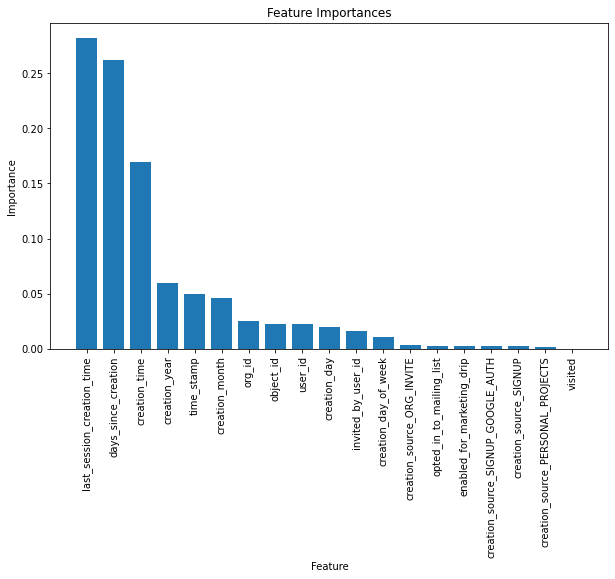

In [272]:
# Print and visualize feature importances
print("\nFeature Importances:")
for i, idx in enumerate(sorted_indices):
    print(f"{features[idx]}: {feature_importances[idx]:.4f}")

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(features)), feature_importances[sorted_indices], align="center")
plt.xticks(range(len(features)), np.array(features)[sorted_indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()
